# Remaining Useful Life Prediction
Documentation: https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/

In [5]:
!git clone "https://github.com/ibm-granite/granite-tsfm.git"
#%cd granite-tsfm
#!pip install ".[notebooks]"
#%cd ../


fatal: destination path 'granite-tsfm' already exists and is not an empty directory.


In [6]:
# Core libraries
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

# TSFM Toolkit libraries
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

# Weights and Biases (WANB) API Key:
# 55786691f5bf98d3d3c2974925c51b1e1622d1d3

ImportError: cannot import name 'nn' from partially initialized module 'torch' (most likely due to a circular import) (c:\Program Files\Python311\Lib\site-packages\torch\__init__.py)

In [ ]:
# Load datasets
with open('../data/processed_data_pickle_files_no_smoothing/test_data_no_batches.pkl', 'rb') as file:
    test_df = pickle.load(file)

with open('../data/processed_data_pickle_files_no_smoothing/test_data_no_batches.pkl', 'rb') as file:
    train_df = pickle.load(file)

# Ensure data are dataframes
if not isinstance(test_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

if not isinstance(train_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

column_names = ['unit_number', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21']

train_df.columns = column_names
train_df.columns = column_names

In [ ]:
# FOR DEVELOPMENT - FILTER TO 5 UNITS
unit_filter = 5
#train_df = train_df[train_df['unit_number'] < (unit_filter + 1)]

In [ ]:
# Add RUL values to the train_df dataframe (unknown for test_df)
train_df['RUL'] = train_df.groupby('unit_number')['unit_number'].transform(lambda x: np.arange(len(x), 0, -1))
#test_df['RUL'] = test_df.groupby('unit_number')['unit_number'].transform(lambda x: np.arange(len(x), 0, -1))

In [ ]:
print(train_df.head(20))

    unit_number  sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  sensor_8  \
0           1.0  1.359276 -0.561495 -0.975674   0.17566  0.209138 -0.539078   
1           1.0 -1.908502  0.070116 -1.392836   0.17566  1.603612 -1.061366   
2           1.0 -0.037636 -0.231698 -0.507676   0.17566  0.517390 -0.364982   
3           1.0 -0.087526 -0.795350  0.251888   0.17566  0.458675 -0.713174   
4           1.0  0.087088 -0.181729 -0.420954   0.17566  0.590783 -1.061366   
5           1.0 -0.910707 -1.794734 -1.436197   0.17566  0.678855 -1.235462   
6           1.0 -0.910707 -0.951254  0.015646   0.17566  0.194459 -0.364982   
7           1.0  0.161923 -1.440952 -0.574960   0.17566 -0.245902 -0.364982   
8           1.0 -1.484439  1.037519  1.128077   0.17566  1.075180 -0.190886   
9           1.0 -1.010486 -0.569490 -0.911381   0.17566  0.766927 -0.539078   
10          1.0 -1.085321 -1.412970 -0.135370   0.17566  1.368753 -0.539078   
11          1.0  0.161923 -0.133758 -1.033987   0.17

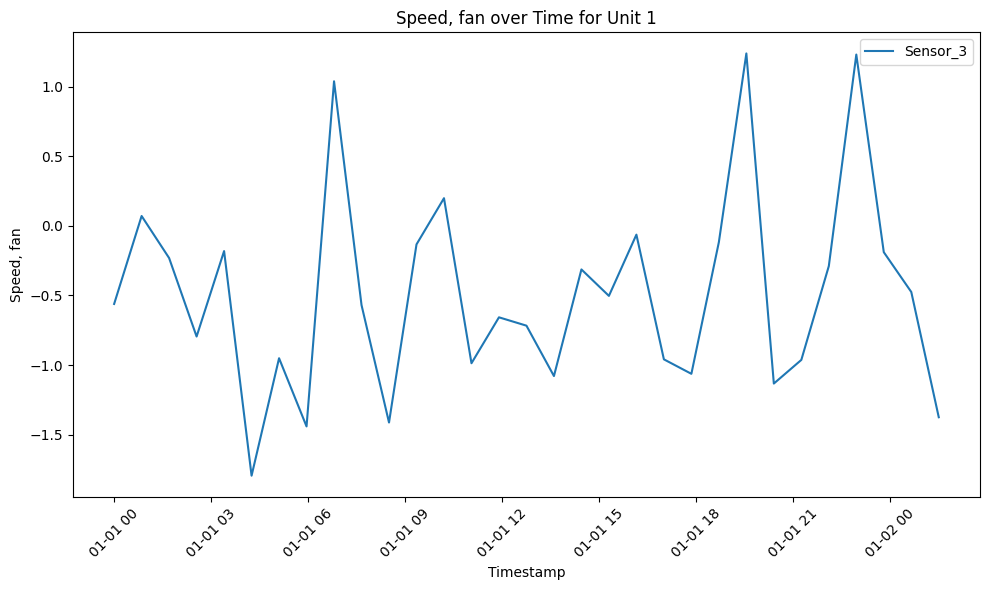

In [ ]:
# Step 1 & 2: Efficiently add empty rows and timestamp for each unit_number
def expand_and_add_timestamp(df, num_empty_rows=50, start_date='2023-01-01'):
    dfs = []
    for unit_num, group in df.groupby('unit_number'):
        N = len(group)
        total_rows = N + (N - 1) * num_empty_rows
        # Create timestamps starting at midnight for each unit_number
        timestamps = pd.date_range(start=start_date, periods=total_rows, freq='min')
        # Create an empty DataFrame with timestamps
        expanded_group = pd.DataFrame({'timestamp': timestamps})
        # Calculate positions to insert the original data
        positions = np.arange(N) * (num_empty_rows + 1)
        # Assign unit_number to the expanded DataFrame
        expanded_group['unit_number'] = unit_num
        # Insert the original data into the correct positions
        expanded_group.loc[positions, group.columns] = group.values
        dfs.append(expanded_group)
    expanded_df = pd.concat(dfs, ignore_index=True)
    return expanded_df

# Step 3: Interpolate the missing values for each unit_number
def interpolate_missing_values(df):
    df = df.set_index(['unit_number', 'timestamp'])
    df = df.interpolate(method='linear')
    df = df.reset_index()
    return df


# Apply the steps to train_df
train_df = expand_and_add_timestamp(train_df)
train_df = interpolate_missing_values(train_df)

# Step 4: Plot 'Speed, fan' for unit_number = 1 over timestamp column
unit_1_data = train_df[train_df['unit_number'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(unit_1_data['timestamp'], unit_1_data['sensor_3'], label='Sensor_3')
plt.xlabel('Timestamp')
plt.ylabel('Speed, fan')
plt.title('Speed, fan over Time for Unit 1')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Refine dataset
train_df = train_df.dropna()
train_df.columns

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21', 'RUL'],
      dtype='object')

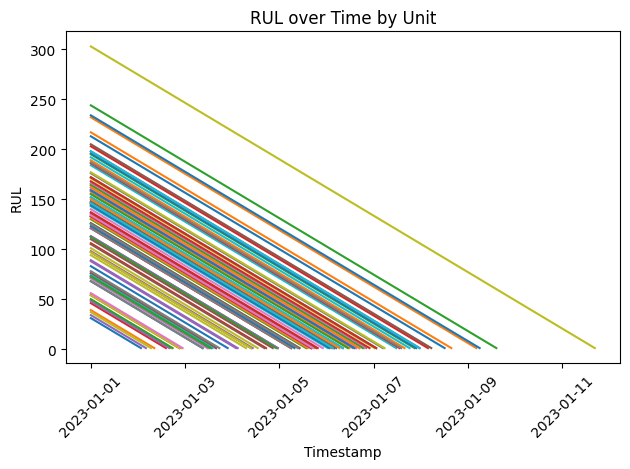

In [ ]:
# Plot RUL over time for each unit in the dataset

# Loop through each unique unit number and plot separately
for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    plt.plot(unit_data['timestamp'], unit_data['RUL'], label=f'Unit {unit}')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('RUL over Time by Unit')
plt.xticks(rotation=45)
#plt.legend()
plt.tight_layout()
plt.show()


# Forecasting

In [ ]:
# Generate train/validation/test split configurations for each unit number in the dataset.
def generate_split_configs(input_df, context_length, unit_numbers=None):

    # If no unit numbers provided, get all unique unit numbers from the data
    if unit_numbers is None:
        unit_numbers = train_df['unit_number'].unique()

    split_configs = {}

    for unit in unit_numbers:
        # Filter data for current unit
        unit_data = input_df[input_df['unit_number'] == unit]
        #unit_data = unit_data.reset_index(drop=True)
        data_length = len(unit_data)

        # Calculate indices for train split (0 to 80%)
        train_start_index = 0
        train_end_index = round(data_length * 0.8)

        # Calculate indices for validation split (80% to 90%)
        # Shift back by context length to ensure first evaluation timestamp follows training data
        eval_start_index = round(data_length * 0.8) - context_length
        eval_end_index = round(data_length * 0.9)

        # Calculate indices for test split (90% to end)
        test_start_index = round(data_length * 0.9) - context_length
        test_end_index = data_length - 1

        # Create split configuration for current unit
        split_configs[unit] = {
            "train": [train_start_index, train_end_index],
            "valid": [eval_start_index, eval_end_index],
            "test": [test_start_index, test_end_index]
        }

    return list(split_configs.values())

In [ ]:
# Function to determine actual vs predicted values
def compare_forecast(forecast, date_col, prediction_col, actual_col, delta):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][delta - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][delta - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

In [ ]:
print(train_df.columns)

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21', 'RUL'],
      dtype='object')


In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future
fewshot_fraction = 0.05 # 5% of the data can be used for few-shot
prediction_filter = 24 # Filter this many predicted time points

# Set column parameters
timestamp_column = "timestamp"
target_columns = ["sensor_2"]
observable_columns = train_df.columns[3:-1]   # Exclude 'unit_number' and 'RUL' columns

# Set up Column Specifiers and Preprocessor
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

{'train': [0, 1225], 'valid': [713, 1378], 'test': [866, 1530]}
1531
Dataset for unit 1 is good


  0%|          | 0/72 [00:00<?, ?it/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kanungle (kanungle-kx-systems). Use `wandb login --relogin` to force relogin


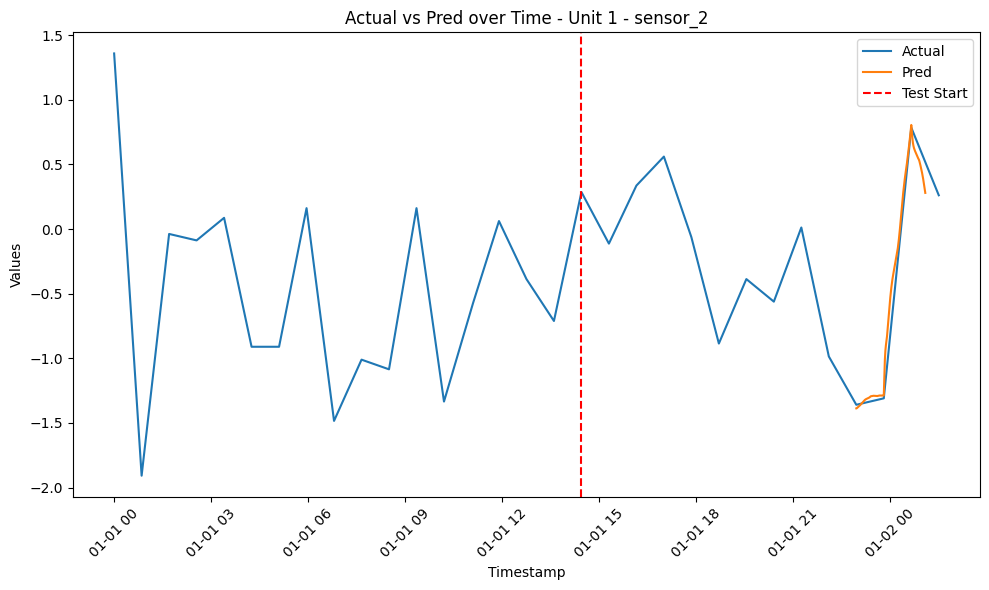

RMSE for Unit 1 - sensor_2: 0.4727575565139362
{'train': [0, 1959], 'valid': [1447, 2204], 'test': [1692, 2448]}
2449
Dataset for unit 2 is good


  0%|          | 0/83 [00:00<?, ?it/s]

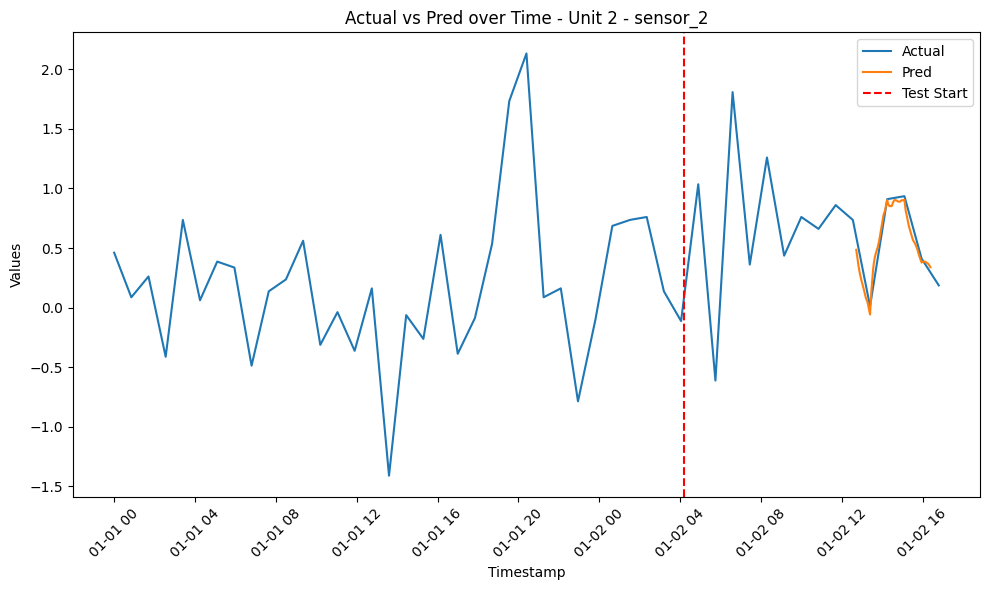

RMSE for Unit 2 - sensor_2: 0.18560477856855015
{'train': [0, 5101], 'valid': [4589, 5738], 'test': [5226, 6375]}
6376
Dataset for unit 3 is good


  0%|          | 0/132 [00:00<?, ?it/s]

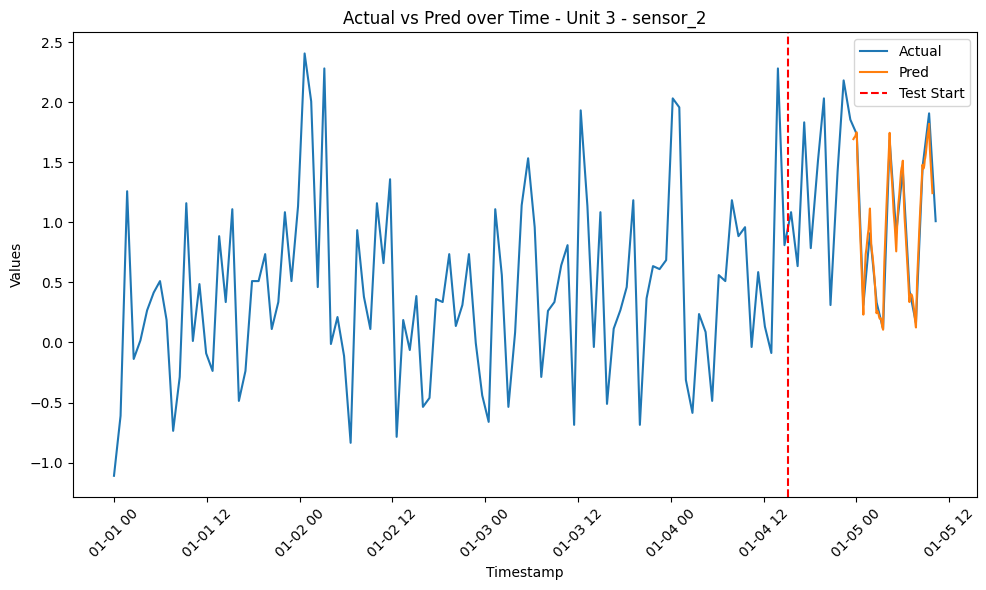

RMSE for Unit 3 - sensor_2: 0.32584042712290656
{'train': [0, 4285], 'valid': [3773, 4820], 'test': [4308, 5355]}
5356
Dataset for unit 4 is good


  0%|          | 0/119 [00:00<?, ?it/s]

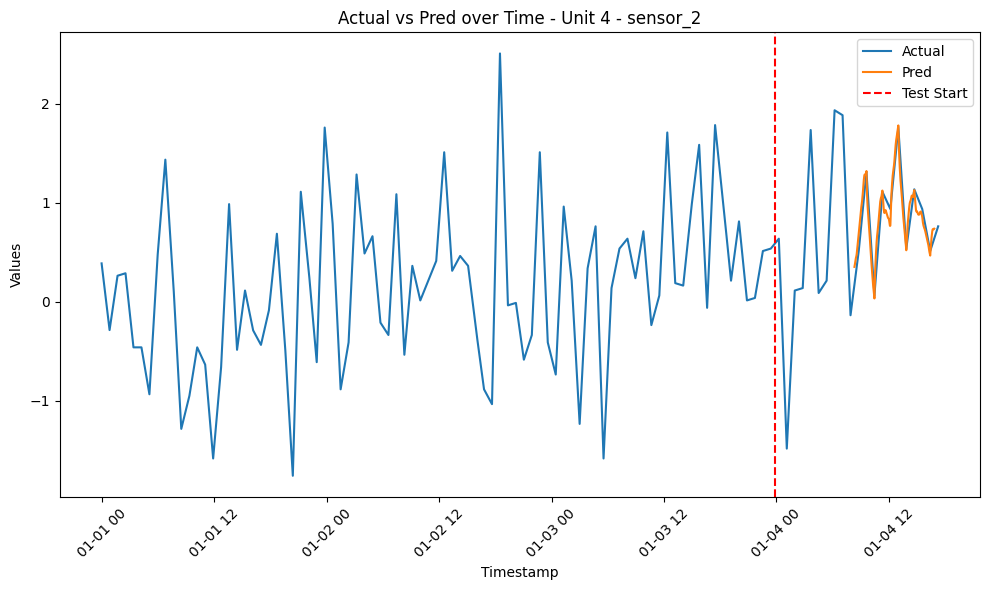

RMSE for Unit 4 - sensor_2: 0.2444264710459406
{'train': [0, 3958], 'valid': [3446, 4453], 'test': [3941, 4947]}
4948
Dataset for unit 5 is good


  0%|          | 0/114 [00:00<?, ?it/s]

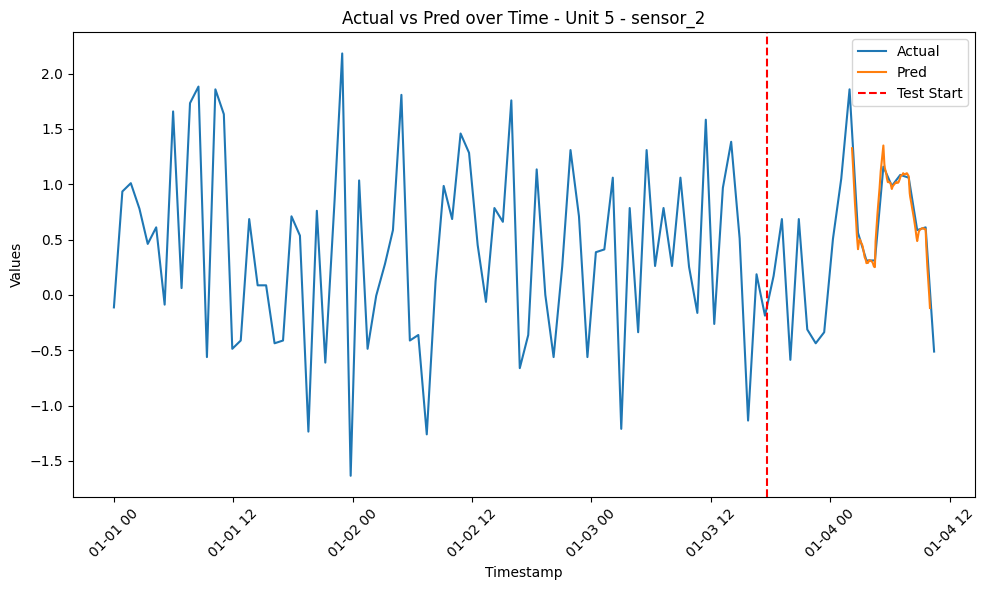

RMSE for Unit 5 - sensor_2: 0.1884562343969509
{'train': [0, 4244], 'valid': [3732, 4774], 'test': [4262, 5304]}
5305
Dataset for unit 6 is good


  0%|          | 0/119 [00:00<?, ?it/s]

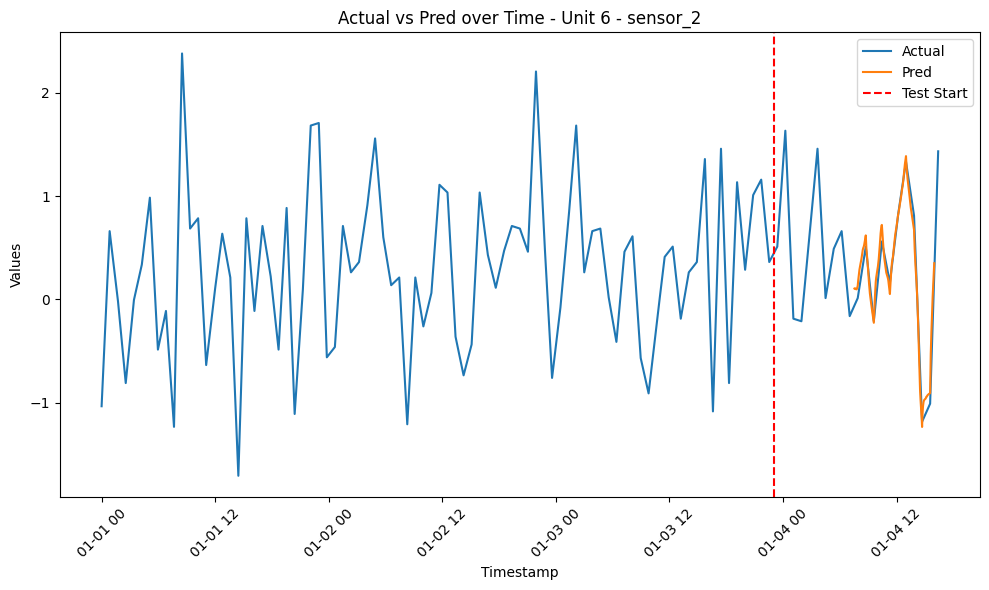

RMSE for Unit 6 - sensor_2: 0.39214497506668133
{'train': [0, 6488], 'valid': [5976, 7299], 'test': [6787, 8109]}
8110
Dataset for unit 7 is good


  0%|          | 0/154 [00:00<?, ?it/s]

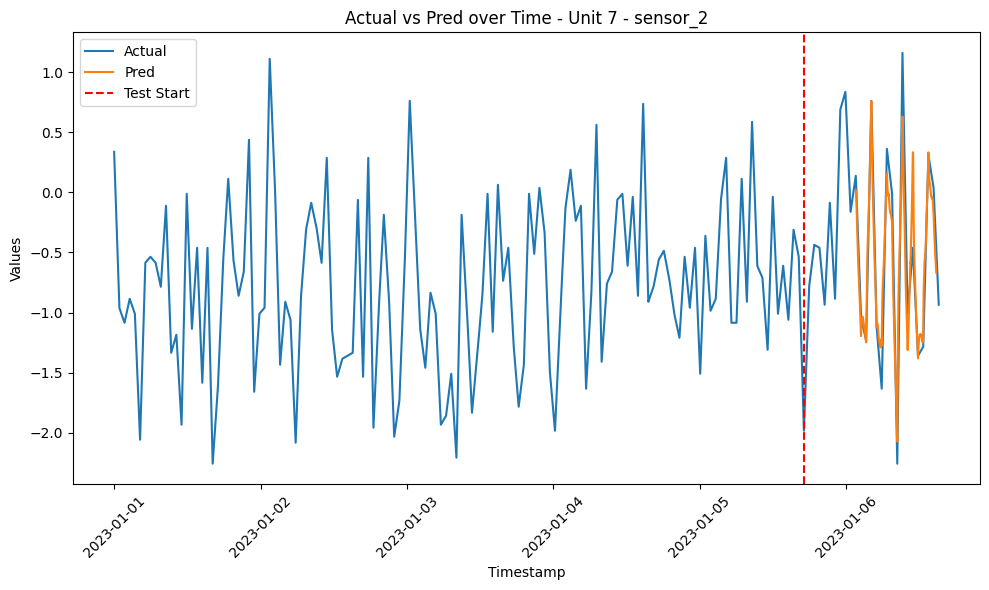

RMSE for Unit 7 - sensor_2: 0.5291545921322168
{'train': [0, 6733], 'valid': [6221, 7574], 'test': [7062, 8415]}
8416
Dataset for unit 8 is good


  0%|          | 0/158 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Forecast each unit's RUL
# Assuming the necessary variables (e.g., train_df, context_length, tsp, timestamp_column, target_columns) are defined

unit_list = []
rmse_list = []
split_configs = generate_split_configs(train_df, context_length)

for unit in train_df['unit_number'].unique():
    unit = int(unit)
    df_subset = train_df[train_df['unit_number'] == unit]
    df_subset = df_subset.reset_index(drop=True)
    split_config = split_configs[unit - 1]  # Access by index


    # Run data checks for debug
    print(split_config)
    print(len(df_subset))
    if df_subset is None or len(df_subset) == 0:
        print(f"No data available for unit {unit}")
    else:
        print(f"Dataset for unit {unit} is good")


    # Reset Preprocessor
    tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=False,
      encode_categorical=True,
      scaler_type="standard",
    )
    
    # Generate datasets based on the split configuration
    #train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config, fewshot_fraction=fewshot_fraction)
    train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config)
    
    # Assign the zeroshot model
    zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=prediction_filter)

    # Initialize trainer with the model
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
    )

    # Evaluate the model on the test dataset
    zeroshot_trainer.evaluate(test_dataset)

    # Create a forecasting pipeline
    zs_forecast_pipeline = TimeSeriesForecastingPipeline(
        model=zeroshot_model,
        device="cpu",
        timestamp_column=timestamp_column,
        id_columns=[],  # Adjust id_columns if needed
        target_columns=target_columns,
        freq="1m"
    )

    # Retrieve test data start and end indices
    test_start_index, test_end_index = split_config['test']

    # Generate forecast
    processed_data = tsp.preprocess(df_subset[test_start_index:test_end_index])
    zs_forecast = zs_forecast_pipeline(processed_data)

    # Compare forecast with actual data and prepare for plotting
    df = compare_forecast(zs_forecast, "timestamp", "sensor_2_prediction", "sensor_2", prediction_filter)
    df.dropna(inplace=True)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(df_subset['timestamp'], df_subset[target_columns], label='Actual', linestyle='-')
    plt.plot(df['timestamp'], df['pred'], label='Pred', linestyle='-')

    # Add labels and legend
    plt.axvline(x=df_subset['timestamp'].iloc[test_start_index], color='red', linestyle='--', label='Test Start')
    plt.xlabel('Timestamp')
    plt.ylabel('Values')
    plt.title('Actual vs Pred over Time - Unit ' + str(unit) + ' - ' + target_columns[0])
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate RMSE for the unit
    rmse = np.sqrt(mean_squared_error(df['actual'], df['pred']))
    print(f"RMSE for Unit {unit} - {target_columns[0]}: {rmse}")
    unit_list.append(unit)
    rmse_list.append(rmse)
    #print("======================================================")
    

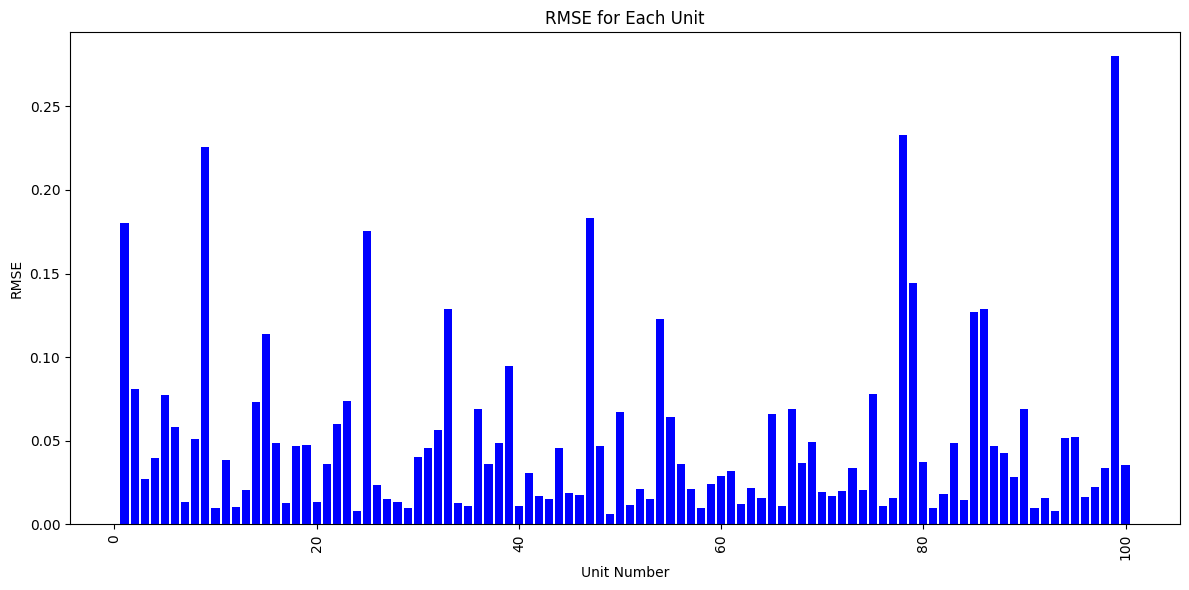

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(unit_list, rmse_list, color='blue')
plt.xlabel('Unit Number')
plt.ylabel('RMSE')
plt.title('RMSE for Each Unit - Sensor 2')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()